In [1]:
import sys
sys.path.append("/home/federico/programming/CM/")

In [2]:
from src.LS.LS import LS
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import random
import sys
import time
import matplotlib.pyplot as plt

from src.NN.utils import *

from datetime import datetime as dt
import time

In [12]:
def generate(m, n):
    """Generates a random dataset starting from the given dimensions.

    :param m: Number of rows for the coefficient matrix (i.e. length of the vector b).
    :param n: Number of columns for the coefficient matrix (i.e. length of the vector x in (P)).
    :return: The coefficient matrix M and the dependent variables vector b.
    """

    M = np.array([ [random.gauss(0,1) for r in range(n)] for c in range(m) ], dtype=np.single)
    b = np.array([random.gauss(0,1) for r in range(m)], dtype=np.single)
    return M, b.reshape(-1,1)


def QR_scaling (starting_m, m, n, step, t, save=True) :
    """Tests the QR factorization for different matrices with m in [200, 5000] and n=50.
    Executes each example for a given amount of time and averages the times accordingly. For each result
    prints the size m and the average execution time, together with the time difference from the previous
    result.

    At the end of the process, saves an image showing the evolution of execution times over the increase
    of dimension m. The resulting image is saved in the resource folder as 'QRscaling_n50.png'.
    """

    print(f"n={n}, m={m}, t={t}")
    print(f"m{'':10} time{'':<6s} delta{'':<5s} time_np{'':<3s} delta_np{'':<7s}")
    print("----------------------------------------------------")
    time_list = []
    time_np = []
    mrange = range(starting_m,m,step)
    prev_a = 0
    prev = 0
    ls = LS()
    for m in mrange:
        A,_ = generate(m,n)
        mean = 0
        mean_np = 0
        for i in range(t):
            startQR = dt.now()
            R = ls.qr(A)
            Q = ls.revertQ()
            QR = np.matmul(Q, R)
            endQR = end_time(startQR)
            endQR = endQR.seconds*1000 + endQR.microseconds/1000
            mean += endQR

            startQRnp = dt.now()
            Qnp, Rnp = np.linalg.qr(A)
            QRnp = np.matmul(Qnp, Rnp)
            endQRnp = end_time(startQRnp)
            endQRnp = endQRnp.seconds*1000 + endQRnp.microseconds/1000
            mean_np += endQRnp
        
        mean = (mean / t)
        mean_np = (mean_np / t)
        delta = mean - prev_a
        delta_np = mean_np - prev
        print(f"{m:<6} || {mean:8.4f} | {delta:8.4f} | {mean_np:8.4f} | {delta_np:8.4f}")
        time_list.append(mean)
        time_np.append(mean_np)
        prev_a = mean
        prev = mean_np

    plt.plot(mrange, time_np, "^-", label="np")

    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n}")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_n{n}m{m}_d{time.time()}.png")
    else: plt.show()
    plt.clf()

    plt.plot (mrange, time_list, "o-", label="mio")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n}")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_n{n}m{m}_d{time.time()}.png")
    else: plt.show()
    plt.clf()
    
    plt.plot(mrange, time_np, "^-", label="np")
    plt.plot (mrange, time_list, "o-", label="(A3)")
    plt.legend()
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n}")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_n{n}m{m}_d{time.time()}.png")
    else: plt.show()
    plt.clf()
    

def automatized_test(M, b, test_type):
    ls = LS()
    m = M.shape[0]
    n = M.shape[1]

    # Computes time for LS solver 
    startLS = dt.now()
    res = ls.solve(M,b)
    endLS = end_time(startLS)

    # Computes time for Q and QR reconstruction
    startQR = dt.now()
    R = ls.qr(M)
    Q = ls.revertQ()
    QR = np.matmul(Q, R)
    endQR = end_time(startQR)


    # Computes QR factorization using numpy
    startQRnp = dt.now()
    Qnp, Rnp = np.linalg.qr(M)
    QRnp = np.matmul(Qnp, Rnp)
    endQRnp = end_time(startQRnp)

    # Computes time for LS solver using numpy
    startLSnp = dt.now()
    resnp, _, _, _ = np.linalg.lstsq(M,b,rcond=-1)
    endLSnp = end_time(startLSnp)


    print(f"---------- {test_type} DATASET ----------")
    print(f"Solved (m x n): ({m},{n}) in {endLS} msec, w/ np in {endLSnp} msec \
    - Reverting and reconstruction: {endQR} msec, w/ np took: {endQRnp} msec")
    print(f"res error: {np.linalg.norm( b - np.dot(M, res) )/np.linalg.norm(b)} "\
    f"- np_res error: {np.linalg.norm( b - np.dot(M, resnp) )/np.linalg.norm(b)}")
    print(f"QR error: {np.linalg.norm( M - QR )/np.linalg.norm(M)} "\
    f"- QR error w/ np: {np.linalg.norm( M - QRnp )/np.linalg.norm(M)}\n")

# Scaling test

n=100, m=11000, t=20
m           time       delta      time_np    delta_np       
----------------------------------------------------
1000   || 197.5095 | 197.5095 |   6.4723 |   6.4723
2000   || 287.5196 |  90.0101 |  12.0431 |   5.5707
3000   || 372.6138 |  85.0942 |  17.5600 |   5.5170
4000   || 469.2772 |  96.6634 |  24.6712 |   7.1111
5000   || 539.5042 |  70.2270 |  28.6959 |   4.0248
6000   || 643.9656 | 104.4613 |  33.3385 |   4.6426
7000   || 705.5320 |  61.5664 |  38.4411 |   5.1026
8000   || 803.9295 |  98.3976 |  42.7404 |   4.2993
9000   || 881.8787 |  77.9492 |  52.9336 |  10.1932
10000  || 1013.2986 | 131.4199 |  64.6754 |  11.7419


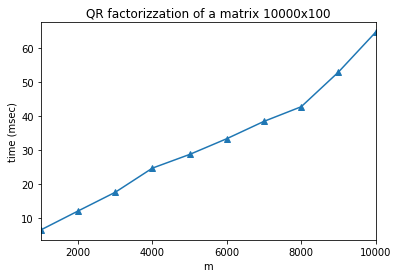

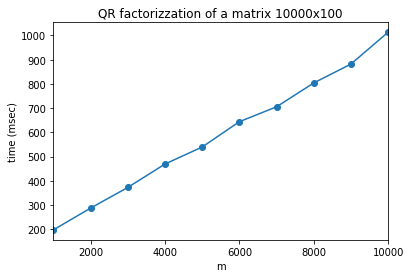

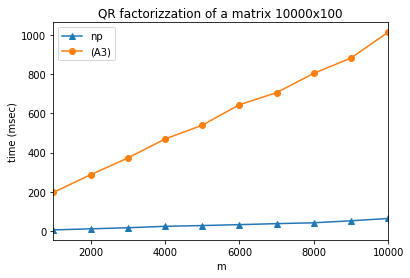

<Figure size 432x288 with 0 Axes>

In [13]:
starting_m = 1000
last_m = 11000
n = 100
step = 1000
repeat = 20
QR_scaling(starting_m, last_m, n, step, repeat, save=False)

In [ ]:
CUP_TEST = 'CUP'
MONK_TEST = 'MONK'
RANDOM_TEST = 'RANDOM'
QR_SCALING = 'SCALING'

if test == CUP_TEST:
    assert len(sys.argv) == 3, "This kind of test requires dataset path to be defined."
    M, b = load_ML_CUP_dataset(sys.argv[2])
    automatized_test(M, b, test)
elif test == MONK_TEST:
    assert len(sys.argv) == 3, "This kind of test requires dataset path to be defined."
    M, b = load_monk(sys.argv[2])
    automatized_test(M, b, test)
elif test == RANDOM_TEST:
    assert len(sys.argv) == 4, "This kind of test requires 'm' and 'n' dimensions to be defined."
    m = int(sys.argv[2])    # number of rows
    n = int(sys.argv[3])    # number of cols
    M, b = generate(m, n)
    automatized_test(M, b, test)